<a href="https://www.kaggle.com/code/erickmoreirav/rainfall-logisticregression-and-gridsearchcv?scriptVersionId=228008093" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Summary 

The objective of this analysis is to predict the probability of rainfall on a specific day based on various meteorological conditions. To achieve this, a logistic regression model will be employed, with the response variable indicating whether rainfall occurs on that day (rainfall = 1). The model will be fitted using the LogisticRegression and GridSearchCV methods from the scikit-learn library to optimize the parameters and predict the likelihood of rainfall.

The training and test datasets contain a single missing value, which will be addressed by imputing the missing data with the mean of the available observations for that specific metric. Finally, an ROC curve will be generated to evaluate the quality of the model’s predictions and assess its performance.

# 2.Load libraries and data set  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score

In [2]:
train=pd.read_csv("/kaggle/input/rainfall/train.csv",na_filter=True,index_col=0)
test=pd.read_csv("/kaggle/input/rainfall/test.csv",na_filter=True)

It is important to note that for the **train** data set the column zero is the index. The column zero is the id of every observation.

# 3. Feature Engineering

It is easy to note that the feature *"temparature"* has been misspelled, renaming this feature to *"temperature"* give more adequate column names for our data sets. The names can also been reviewed one by one with the help of a for cycle and **colname** method. 

In [3]:
train = train.rename(columns={'temparature': 'temperature'})
test = test.rename(columns={'temparature': 'temperature'})

for colname in train:
    print(colname)

day
pressure
maxtemp
temperature
mintemp
dewpoint
humidity
cloud
sunshine
winddirection
windspeed
rainfall


# 4. EDA

To visualize the density distribution and relations between the features and the existence of rainfall in the train data set the **pairplot** method of **seaborn** is used. It is important to notice that the "day" is not showed in theplot

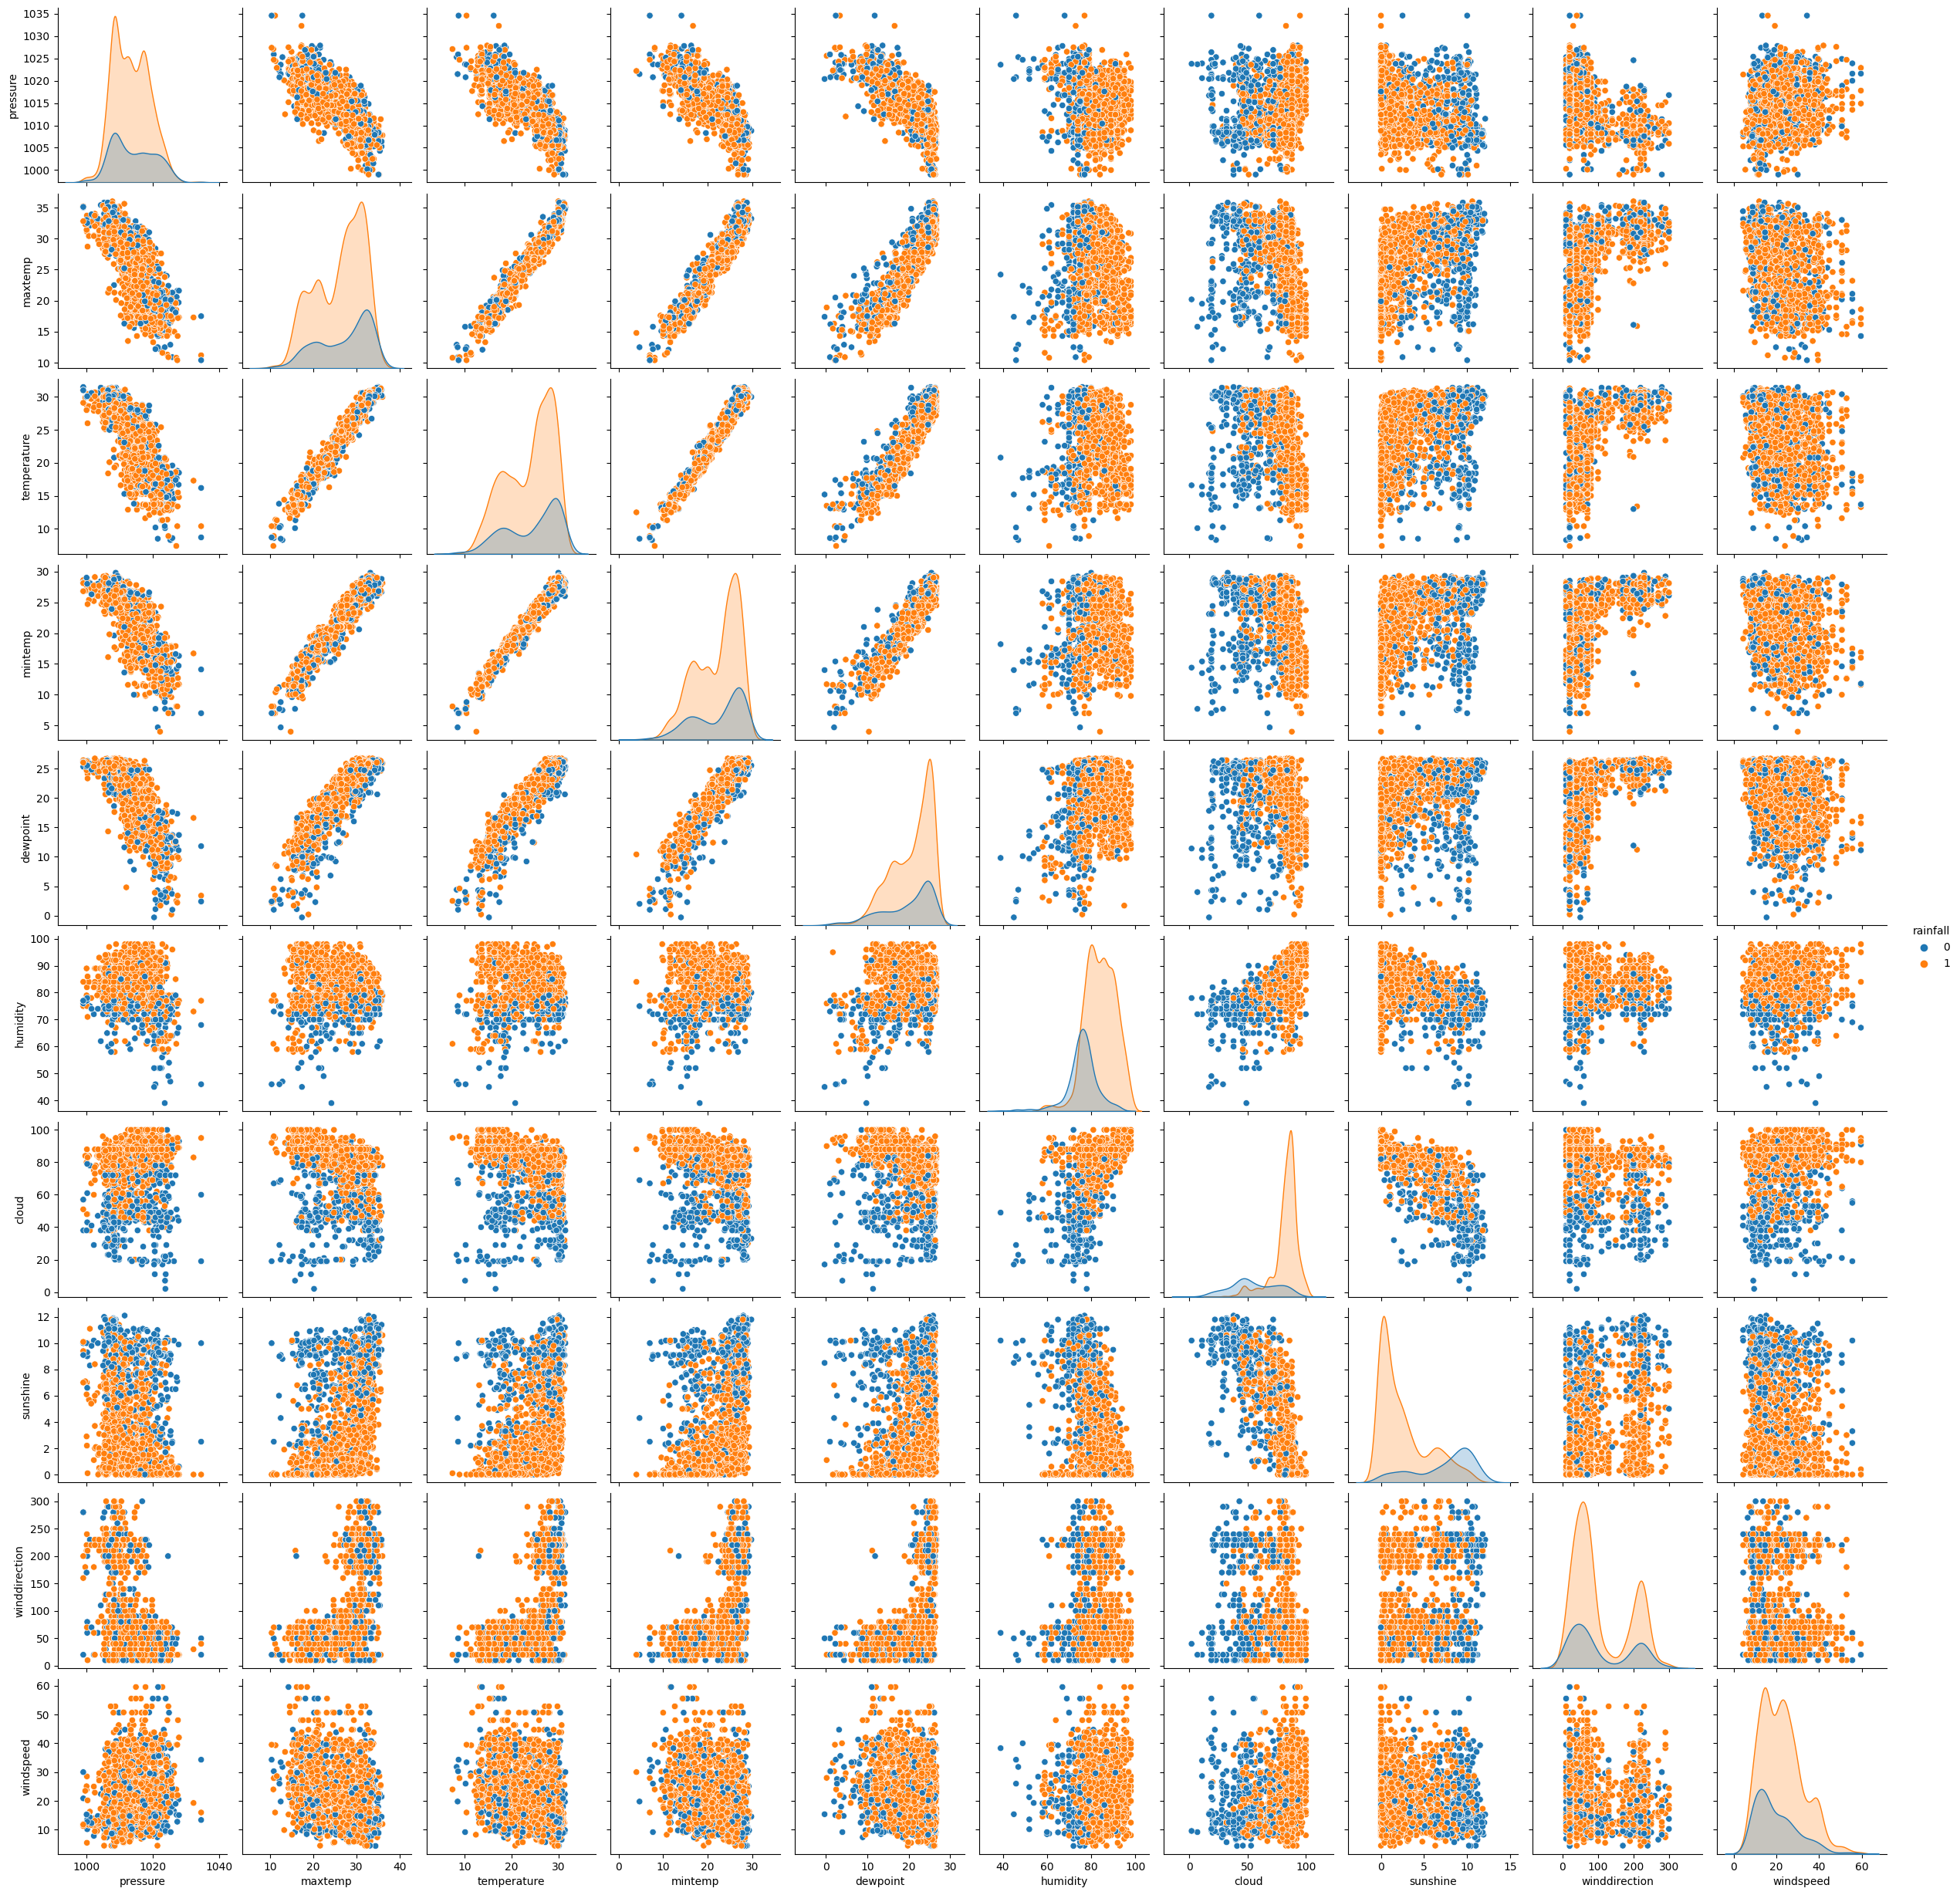

In [4]:
# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.pairplot(train.iloc[:, 1:12], hue = 'rainfall', diag_kind='kde')


It is clear that the "temperatures" features are extremely correlated, even could appear that they are the same variables . Letssee the comparison for the minimum , mean and maximum temperature.

<function matplotlib.pyplot.show(close=None, block=None)>

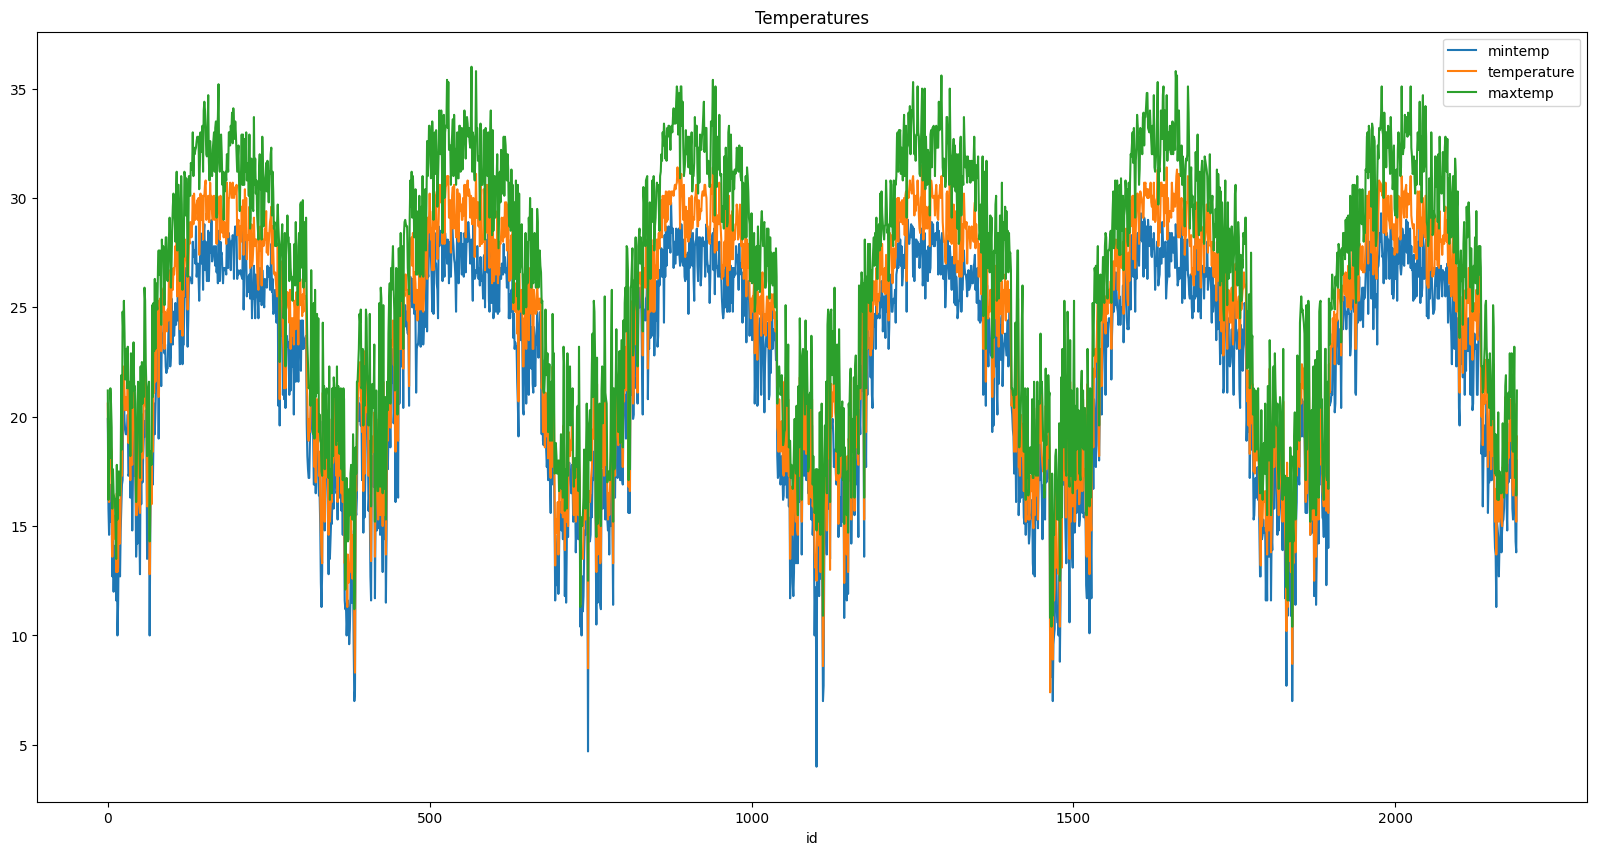

In [5]:
train.plot.line(y=["mintemp","temperature","maxtemp"],figsize=(20,10))
plt.title("Temperatures")
plt.show

As inferred, these variables exhibit a high degree of correlation, and adding a constant value to one variable effectively results in the other. In mathematical terms, this relationship can be expressed as mintemp(𝑖𝑑+𝑐)=temp(𝑖𝑑),wherec represents the constant difference between the two variables.

Is the moment to  identify and replace the Nan observation 

In [6]:
rows_with_na = test[test.isna().any(axis=1)]
print(rows_with_na.head())

       id  day  pressure  maxtemp  temperature  mintemp  dewpoint  humidity  \
517  2707  153    1007.8     32.9         30.6     28.9      22.0      65.0   

     cloud  sunshine  winddirection  windspeed  
517   75.0       8.2            NaN       17.2  


In the id 2707 of the test set, there is a missing value. I will replace this value with the median because the feature winddirection is bimodal. 

In [7]:
val=int(test["winddirection"].median())
test=test.fillna(val)

In [8]:
#Checking that there are no remainings missing values 
rows_with_na = test[test.isna().any(axis=1)]
print(rows_with_na)

Empty DataFrame
Columns: [id, day, pressure, maxtemp, temperature, mintemp, dewpoint, humidity, cloud, sunshine, winddirection, windspeed]
Index: []


# 5. Logistic Regression

Extract the covariates values and the response values and then split for the train and test data set of the model. I chose 0.20 for the test size in order to be conservative (The 0.20 is the proportion of the total observations that will be in the test data) .  

In [9]:
X=train.loc[:,"pressure":"windspeed"].values
y =train.rainfall.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

The initial step involves fitting a logistic regression model with an \( L2 \) (Ridge) penalty. A tuning parameter, \( C > 0 \), controls the strength of the penalty, with larger values of \( C \) corresponding to a weaker penalty. To optimize this hyperparameter, I employed cross-validation on the training set using **GridSearchCV**. The cross-validation strategy, defined by the CV parameter, will be based on the default 5-fold cross-validation. This approach ensures that the model is evaluated thoroughly across different subsets of the training data.

In [10]:
#Create the LR model 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()

In [11]:
grid = { 'C':[0.1, 1, 10, 100, 1000] }
model = GridSearchCV(LogisticRegression(penalty="l2", max_iter=1000),
grid, scoring="accuracy", cv=5)
model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10, 100, 1000]}, scoring='accuracy')

**The selected hyperparameter was:**

In [12]:
print(model.best_params_)

{'C': 1}


The coefficients for every covariates are: 

In [13]:
coef = pd.Series(model.best_estimator_.coef_[0,:])
coef.index =train.columns[1:-1]
print(coef)

pressure        -0.008059
maxtemp          0.052897
temperature     -0.068050
mintemp         -0.057283
dewpoint         0.155989
humidity         0.038310
cloud            0.067558
sunshine        -0.147478
winddirection   -0.000162
windspeed        0.017685
dtype: float64


Certain covariates, such as wind direction and pressure, have minimal impact on predicting the probability of rainfall. In contrast, the dew point exhibits a strong positive influence, while sunshine shows a significant negative effect. 

# 6.Metrics and ROC

In [14]:
from sklearn.metrics import accuracy_score
print(f"The accuracy is {accuracy_score(y_train, model.predict(X_train)):,.3f}")

The accuracy is 0.869


In [15]:
#The predictions in the X_test
y_pred=model.predict(X_test)

**Classification report**

In [16]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       100
           1       0.90      0.92      0.91       338

    accuracy                           0.86       438
   macro avg       0.81      0.79      0.80       438
weighted avg       0.86      0.86      0.86       438



Based on the classification report here’s a detailed analysis of the model’s performance:

### **General Model Performance**:
- **Accuracy**: The model's overall accuracy is generally good, but accuracy alone might not be sufficient to evaluate performance, especially when dealing with imbalanced classes.

### Conclusion:
- **Strengths**: The model performs very well for predict rainfall days (the majority class), with high precision, recall, and F1-score. The overall accuracy is promising.
- **Weaknesses**: The model underperforms for no rainfall days (the minority class), with a notable drop in recall and a lower F1-score . This suggests that the model may have difficulty detecting the minority class, potentially due to class imbalance.
  


<Axes: >

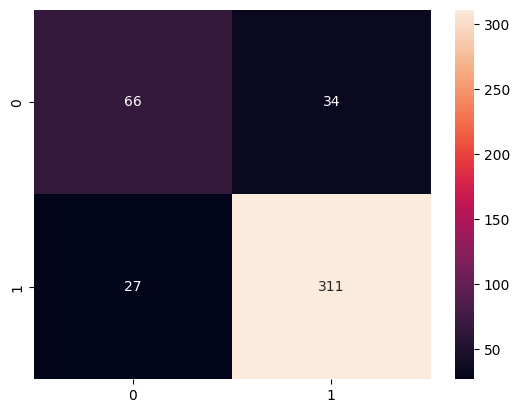

In [17]:
#Visual heatmap
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt=".0f")

In [18]:
#Calculations to get the ROC curve
y_predprob=model.predict_proba(X_train)
fpr,tpr,threshold = roc_curve(y_train,y_predprob[:,1]) #target 1 probability

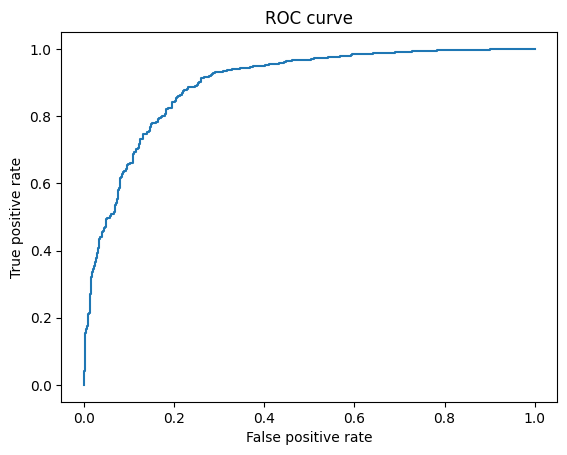

In [19]:
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig('ROC_curve.png')

In [20]:
print(f"The area under the curve of the ROC plot is {auc(fpr,tpr):.2f}")

The area under the curve of the ROC plot is 0.90


An AUC near 1 is an excellent result, signaling that the model is performing very well in distinguishing between the two types (rainfall and no rainfall). This complements the previously mentioned precision, recall, and F1-score metrics, further reinforcing the effectiveness of the model, particularly in the context of a potentially imbalanced dataset.

# 7.Submitting the prediction file

In [21]:
test2=test.loc[:,"pressure":"windspeed"].values
r_test=pd.Series(model.predict_proba(test2)[:,1])

In [22]:
output= pd.DataFrame({'id':test["id"],'rainfall':r_test})

In [23]:
output.to_csv('/kaggle/working/submission.csv',index=False)